In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import json
import glob
import os
from shutil import move, copy
import easyocr
from ultralytics import YOLO

In [2]:
df = pd.read_csv('../data/interim/annots_imgs_merged.csv')
barh = df[df['chart-type'] == 'horizontal_bar']
barh = barh[['chart-type','data-series','visual-elements.bars','file_name', 'image_path']]
barh = barh.reset_index(drop=True)
barh.columns = ['type','data_series','data','name','path']
barh.head()

,type,data_series,data,name,path
0,horizontal_bar,"[{'y': 'Goal 17', 'x': 21}, {'y': 'Goal 16', '...","[{'height': 8, 'width': 228, 'x0': 62, 'y0': 5...",996fc1c90e80,../data/interim/BarHplots/996fc1c90e80.jpg
1,horizontal_bar,"[{'y': 'Accuracy of Order', 'x': 95}, {'y': 'O...","[{'height': 30, 'width': 384, 'x0': 115, 'y0':...",43a6f95994b3,../data/interim/BarHplots/43a6f95994b3.jpg
2,horizontal_bar,"[{'y': '18', 'x': 85436}, {'y': '17', 'x': 454...","[{'height': 4, 'width': 414, 'x0': 46, 'y0': 1...",2e7492322558,../data/interim/BarHplots/2e7492322558.jpg
3,horizontal_bar,"[{'y': 'Other family and relatives', 'x': 1.94...","[{'height': 19, 'width': 21, 'x0': 128, 'y0': ...",f3df28f1d4b0,../data/interim/BarHplots/f3df28f1d4b0.jpg
4,horizontal_bar,"[{'y': 'Both Latin/a', 'x': 0}, {'y': 'Both As...","[{'height': 7, 'width': 0, 'x0': 128, 'y0': 15...",fdc8e5c9ca09,../data/interim/BarHplots/fdc8e5c9ca09.jpg


In [4]:
dataframes = []
for i in range(len(barh)):
    # extract xy coordinates from data_coords column
    coords = barh['data'][i]
    coords = coords.replace("'", "\"")
    coords_list = json.loads(coords)

    # extract important image info
    path = barh['path'][i]
    name = barh['name'][i]
    img = cv2.imread(path)
    height = img.shape[0]
    width = img.shape[1]

    # Save the xy coords into a list
    bbox = []
    for data in coords_list:

        x1 = data['x0']
        y1= data['y0']
        w = data['width']
        h = data['height']
        x2 = x1 + w
        y2 = y1 + h

        x_center = (x1+x2)/(2*width)
        y_center = (y1+y2)/(2*height)
        yolo_width = w/width
        yolo_height = h/height
        bbox.append((x_center, y_center, yolo_width, yolo_height))
  
   

    # Save into list of dataframe
    yolo = pd.DataFrame(bbox, columns=['x','y','w','h'])
    yolo['class'] = 0
    yolo['path'] = path
    yolo['name'] = name
    yolo = yolo[['path','name','class','x','y','w','h']]
    dataframes.append(yolo)

# Concat dataframes and check that the number of unique images is correct
yolo_df = pd.concat(dataframes)


In [12]:
yolo_df['path'].nunique()

73

In [15]:
unique_images = yolo_df['path'].unique()
img_df = pd.DataFrame(unique_images,columns=['path'])
img_train = tuple(img_df.sample(frac=0.8)['path'])
img_test = tuple(img_df.query(f'path not in {img_train}')['path'])
len(img_train), len(img_test)

(58, 15)

In [16]:
train_df = yolo_df.query(f'path in {img_train}')
test_df = yolo_df.query(f'path in {img_test}')

In [27]:
src_folder = '../data/interim/BarHplots'
train_folder = '../data/YOLO/BarHplots/train/'
test_folder = '../data/YOLO/BarHplots/test/'

In [18]:
cols = ['name','class','x','y','w','h']
groupby_obj_train = train_df[cols].groupby('name')
groupby_obj_test = test_df[cols].groupby('name')

In [20]:
def save_data(filename, folder_path, group_obj):
    #copy image
    src = os.path.join(src_folder,filename)+'.jpg'
    dst = os.path.join(folder_path, filename)+'.jpg'
    copy(src, dst)

    #save labels
    text_filename = os.path.join(folder_path,filename+'.txt')
    group_obj.get_group(filename).set_index('name').to_csv(text_filename, index=False, header=False, sep=' ')

In [28]:
filename_series = pd.Series(groupby_obj_train.groups.keys())
filename_series.apply(save_data,args=(train_folder, groupby_obj_train))

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
21    None
22    None
23    None
24    None
25    None
26    None
27    None
28    None
29    None
30    None
31    None
32    None
33    None
34    None
35    None
36    None
37    None
38    None
39    None
40    None
41    None
42    None
43    None
44    None
45    None
46    None
47    None
48    None
49    None
50    None
51    None
52    None
53    None
54    None
55    None
56    None
57    None
dtype: object

In [29]:
filename_series_test = pd.Series(groupby_obj_test.groups.keys())
filename_series_test.apply(save_data,args=(test_folder, groupby_obj_test))

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
dtype: object

In [30]:
model = YOLO('yolov8n.yaml')


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

In [31]:
model.train(data='../data/YOLO/BarHplots/data.yaml', epochs=100)

New https://pypi.org/project/ultralytics/8.0.134 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.124 🚀 Python-3.11.3 torch-2.0.1 CPU
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=../data/YOLO/BarHplots/data.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, 

In [3]:
model = YOLO('/Users/matt/Desktop/graphs-capstone/models/barHplot_model.pt') 

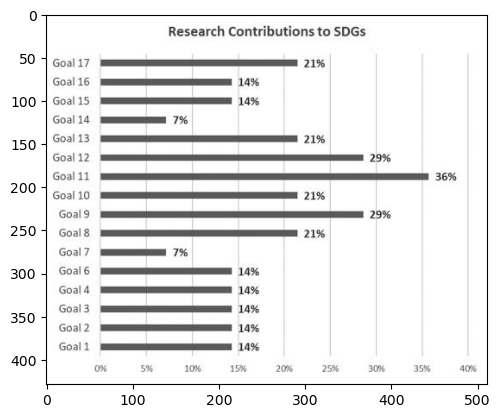

In [5]:
# Test image
path = barh['path'].values[0]
img = cv2.imread(path)
plt.imshow(img)
plt.show()


image 1/1 /Users/matt/Desktop/graphs-capstone/notebooks/../data/interim/BarHplots/996fc1c90e80.jpg: 544x640 16 bars, 514.3ms
Speed: 11.7ms preprocess, 514.3ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)


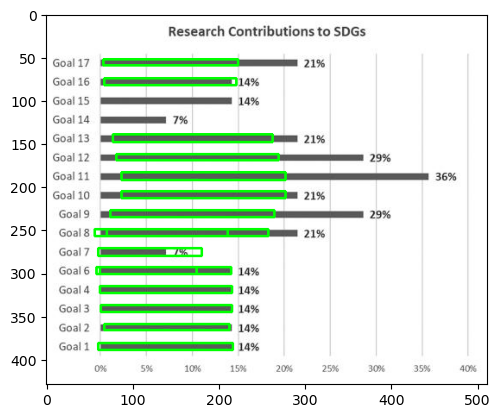

In [4]:
sample = cv2.imread(barh['path'][0])
results = model(barh['path'][0])

bbox_pred = []
res = results[0].boxes.data

for bbox in res:
    x1, y1, x2, y2, probs, pred = bbox
    bbox_pred.append((int(x1.item()), int(y1.item()), int(x2.item()), int(y2.item())))

for bbox in bbox_pred:
    x1, y1, x2, y2 = bbox
    cv2.rectangle(sample, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.imshow(sample)
plt.show()